# Lab 4
This is a jupyter notebook for lab 4. First we will import some libraries and functions. 

In [1]:
import numpy as np
from netCDF4 import MFDataset 
from netCDF4 import Dataset 
import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from netCDF4 import num2date
from netCDF4 import date2index
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
import cartopy.util as cutil
%matplotlib inline

Our next setep is to read in the netCDF files. 

In [2]:
ds = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc')
ds2 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/slp.mon.mean.nc')
ds3 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/uwnd.mon.mean.nc')
ds4 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/vwnd.mon.mean.nc')


Indicate the desired year and month!

In [8]:
year = 1979
month = 1
monthlabel = 'January'

# These lines are needed for the indexing within Python 
# Don't change these!!
ty = int(year) - 1948
tm = int(month)-1

From the first file, we extract latitude, longitude and our variables of interest.  

In [9]:
# Grab lat/lon values
lats = ds.lat.data
lons = ds.lon.data

#subtract 1 from tm because the first observation in Python is observation 0

temp = ds.air[tm::12,:,:]
slp = ds2.slp[tm::12,:,:]
vwnd = np.asarray(ds4.vwnd.values[:][tm::12,:,:] * units('m/s'))
uwnd = np.asarray(ds3.uwnd.values[:][tm::12,:,:] * units('m/s'))
u_barbs = ds3.uwnd.values[:][tm::12,:,:] * units('m/s')
v_barbs = ds4.vwnd.values[:][tm::12,:,:] * units('m/s')

Print the numpy shapes of the temperature, latitude and longtitude. This can be important when debugging.

In [10]:
print (np.shape(slp))
print (np.shape(lats))
print (np.shape(lons))

(73, 73, 144)
(73,)
(144,)


Select the countour settings for the height anomalies (in m) and heights. The format is (minimum, maximum, interval) 

In [11]:
clevs_slp_anom = np.arange(-16, 16.1, 2)
clevs_slp = np.arange(0, 1080, 4)

Make the map!

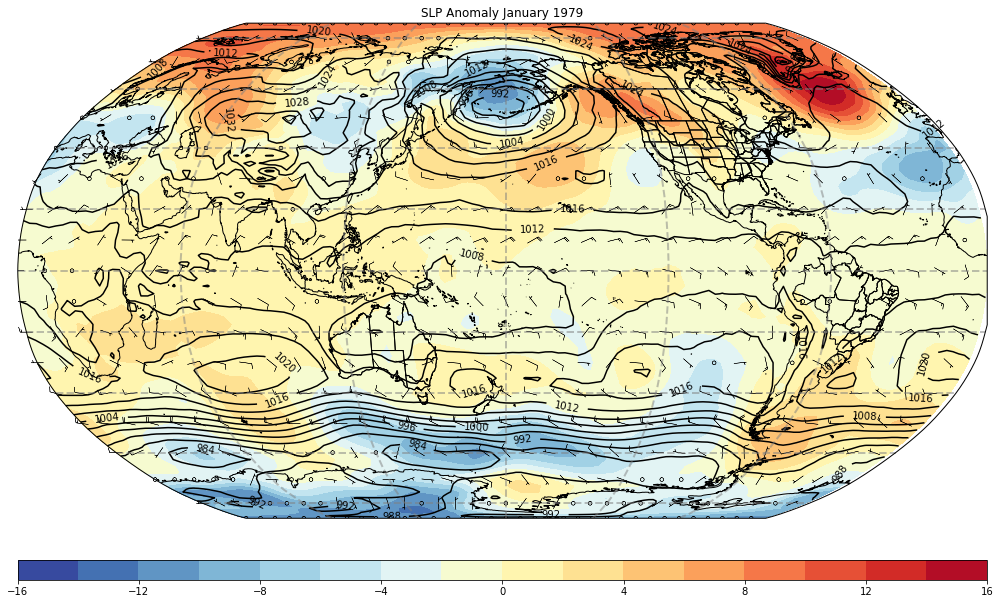

In [12]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.Robinson(central_longitude=180)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)

#not needed here, but used for sub-setting domain to plot
#ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
gl = ax.gridlines(color='gray',linewidth=2, alpha = 0.5, linestyle='--')

# labels gridlines for PlateCarree ccrs option (doesn't work with Robinson, etc.)
#gl.xlabels_top = False
#gl.ylabels_right = False

#color-filled contour time!
cf = ax.contourf(lons, lats, slp[ty,:,:] - np.mean(slp[:,:,:],axis=0), clevs_slp_anom, cmap=plt.cm.RdYlBu_r, transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)

# Plot SLP Anomaly
#cs = ax.contour(lons, lats, hght[ty,:,:] - np.mean(hght[:,:,:],axis=0), clevs_hght_anom, colors='black', transform=datacrs)
#plt.clabel(cs, fmt='%d')

# Plot SLP
cs = ax.contour(lons, lats, slp[ty,:,:], clevs_slp, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons[::4], lats[::4], u_barbs.to('kt')[ty,::4,::4].m, 
         v_barbs.to('kt')[ty,::4,::4].m, pivot='middle',
         color='black', transform=datacrs, length=5, linewidth=0.4)

# Make some nice titles for the plot (one right, one left)
plt.title('SLP Anomaly ' + str(monthlabel) + ' ' +str(year))

# Reduce excessive white space around image and show
plt.tight_layout()
plt.savefig('SLPAnomaly' + str(monthlabel) + str(year), dpi=150)
plt.show()